# Price Exploration

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
from web3 import Web3
from dotenv import load_dotenv
import ccxt
import os
import pandas as pd
from datetime import datetime
import numpy as np
from datafetcher import DataFetcher
import matplotlib.pyplot as plt

# Chainlink

We could use Chainlink, but probably okay and more convenient to use ccxt for "true" prices. Chainlink is especially annoying since you have to specify rounds instead of timestamps.

In [4]:
load_dotenv()
INFURA_KEY = os.getenv("INFURA_KEY")

# Change this to use your own RPC URL
web3 = Web3(Web3.HTTPProvider(f"https://mainnet.infura.io/v3/{INFURA_KEY}"))

# AggregatorV3Interface ABI
abi = '[{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"description","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint80","name":"_roundId","type":"uint80"}],"name":"getRoundData","outputs":[{"internalType":"uint80","name":"roundId","type":"uint80"},{"internalType":"int256","name":"answer","type":"int256"},{"internalType":"uint256","name":"startedAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint80","name":"answeredInRound","type":"uint80"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"latestRoundData","outputs":[{"internalType":"uint80","name":"roundId","type":"uint80"},{"internalType":"int256","name":"answer","type":"int256"},{"internalType":"uint256","name":"startedAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint80","name":"answeredInRound","type":"uint80"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"version","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"}]'
# Price Feed address
addr = '0x8fFfFfd4AfB6115b954Bd326cbe7B4BA576818f6'

addr = web3.to_checksum_address(addr)

# Set up contract instance
contract = web3.eth.contract(address=addr, abi=abi)

#  Valid roundId must be known. They are NOT incremental.
valid_round_id = 36893488147419104482
# valid_round_id = 0

sample = contract.functions.getRoundData(valid_round_id).call()
decimals = contract.functions.decimals().call()
print(sample[1]/10**decimals)
# contract.functions.latestRoundData().call()

1.00012638


# Using CCXT

Thought: create a stack of excahnges and try getting USD/ETH (depending on peg) prices for each of them. If getting prices fails, pop from the stack and try on the next exchange (e.g. binanceus, binance, coinbase, kraken, etc..)

In [5]:
datafetcher = DataFetcher('2023-03-01', '2023-04-01')
df = datafetcher.get_ohlcv('USDC/USD', '1m')
df

Fetching OHLCV for USDC/USD using Binance US...


,timestamp,open,high,low,close,volume
datetime,,,,,,
2023-03-01 05:01:00,1677646860000,1.0001,1.0001,1.0001,1.0001,72.69
2023-03-01 05:02:00,1677646920000,1.0001,1.0003,1.0001,1.0003,76.17
2023-03-01 05:03:00,1677646980000,1.0001,1.0003,1.0001,1.0003,77.41
2023-03-01 05:04:00,1677647040000,1.0000,1.0003,1.0000,1.0003,938.65
2023-03-01 05:05:00,1677647100000,1.0003,1.0003,1.0003,1.0003,73.74
...,...,...,...,...,...,...
2023-04-01 10:56:00,1680346560000,1.0000,1.0000,1.0000,1.0000,0.00
2023-04-01 10:57:00,1680346620000,1.0000,1.0001,1.0000,1.0001,2993.92
2023-04-01 10:58:00,1680346680000,1.0001,1.0001,1.0001,1.0001,23.63


<Axes: xlabel='datetime'>

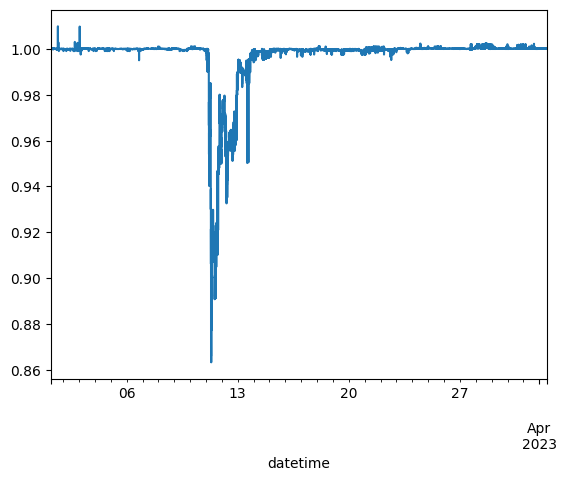

In [6]:
df['close'].plot()

In [7]:
df[df['close']==0.8633]

,timestamp,open,high,low,close,volume
datetime,,,,,,
2023-03-11 07:55:00,1678521300000,0.8799,0.88,0.8625,0.8633,36876.62


# CCXT Price Vol

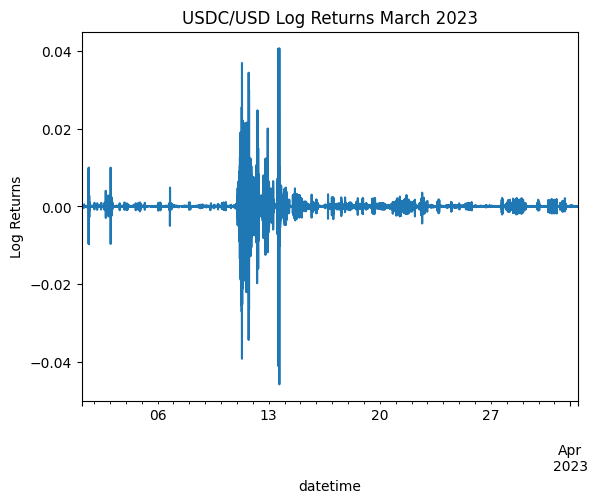

In [15]:
df['returns'] = df['close']/df['close'].shift()
df['log_returns'] = np.log(df['returns'])
df['log_returns'].plot(title='USDC/USD Log Returns March 2023', ylabel='Log Returns')
plt.savefig('./figs/log_returns.png')

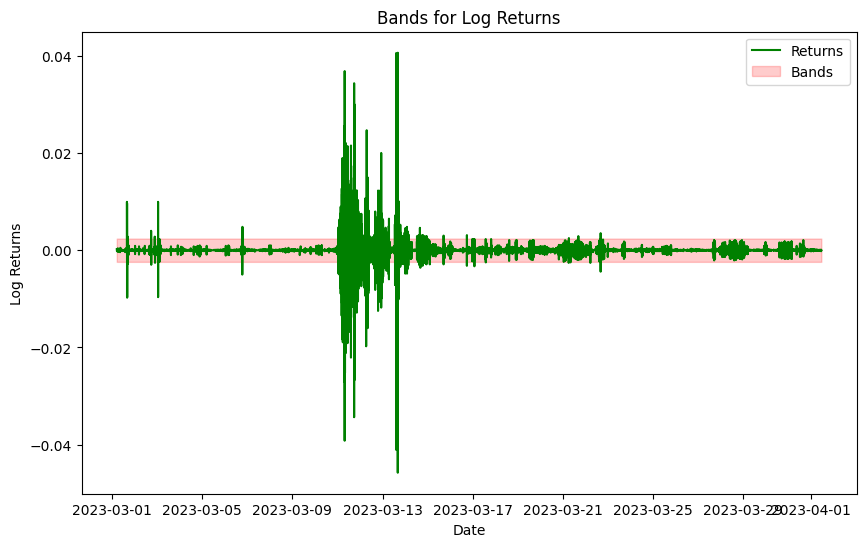

In [75]:
tmp = df.copy()
# tmp = tmp.loc['2023-03-11':'2023-03-13']
n = 2

# Calculate the rolling mean and standard deviation with window=60
rolling_mean = tmp['log_returns'].rolling(window=1).mean()
rolling_std = tmp['log_returns'].rolling(window=60*24).std()

# Calculate the upper and lower Bollinger Bands
# upper_band = rolling_mean + n * rolling_std
# lower_band = rolling_mean - n * rolling_std
upper_band = tmp['log_returns'].mean() + n * tmp['log_returns'].std()
lower_band = tmp['log_returns'].mean() - n * tmp['log_returns'].std()

# Plot the timeseries and the Bollinger Bands
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(tmp['log_returns'], label='Log Returns')
ax.plot(rolling_mean, label='Returns', color='green')
ax.fill_between(tmp.index, lower_band, upper_band, alpha=0.2, color='red', label='Bands')
ax.legend(loc='best')
ax.set_title('Bands for Log Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')

fig.savefig('./figs/simple_bands.png')

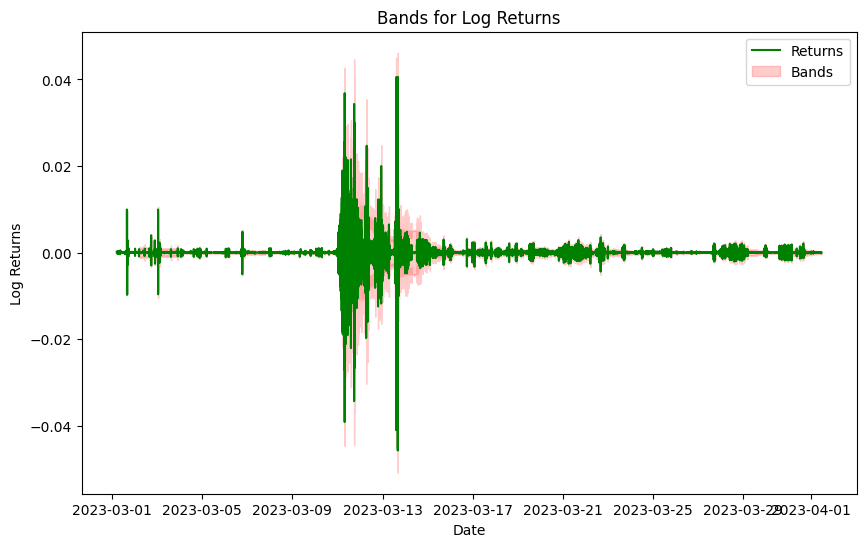

In [77]:
tmp = df.copy()
# tmp = tmp.loc['2023-03-11':'2023-03-13']
n = 2

# Calculate the rolling mean and standard deviation with window=60
rolling_mean = tmp['log_returns'].rolling(window=1).mean()
rolling_std = tmp['log_returns'].rolling(window=60*24).std()

# Calculate the upper and lower Bollinger Bands
upper_band = rolling_mean + n * rolling_std
lower_band = rolling_mean - n * rolling_std

# Plot the timeseries and the Bollinger Bands
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(tmp['log_returns'], label='Log Returns')
ax.plot(rolling_mean, label='Returns', color='green')
ax.fill_between(tmp.index, lower_band, upper_band, alpha=0.2, color='red', label='Bands')
ax.legend(loc='best')
ax.set_title('Bands for Log Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')

fig.savefig('./figs/simple_bands.png')

<Axes: xlabel='datetime'>

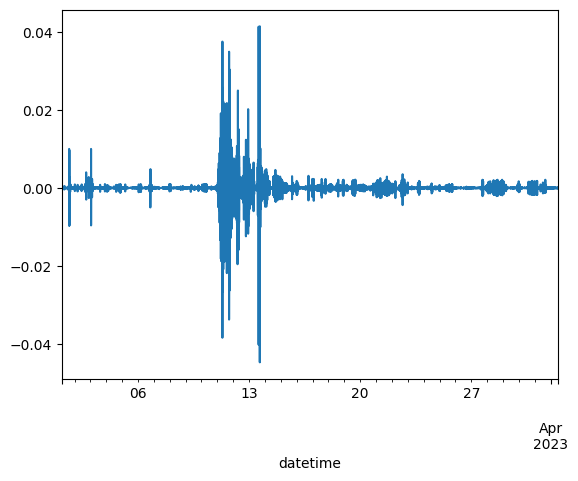

In [85]:
ts = df['close'].pct_change().dropna()
ts.plot()

In [103]:
import statsmodels.api as sm 
mod_kns = sm.tsa.MarkovRegression(ts, k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  close   No. Observations:                44999
Model:               MarkovRegression   Log Likelihood              594022.188
Date:                Tue, 02 May 2023   AIC                       -1188036.376
Time:                        19:29:09   BIC                       -1188001.519
Sample:                    03-01-2023   HQIC                      -1188025.404
                         - 04-01-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.095e-14        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.829e-06   1.71e-07     57.351      0.000    9.49e-06    1.02e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8900      0.002    568.518      0.000       0.887       0.893
p[1->0]        0.6468      0.001    568.519      0.000       0.645       0.649
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: xlabel='datetime'>

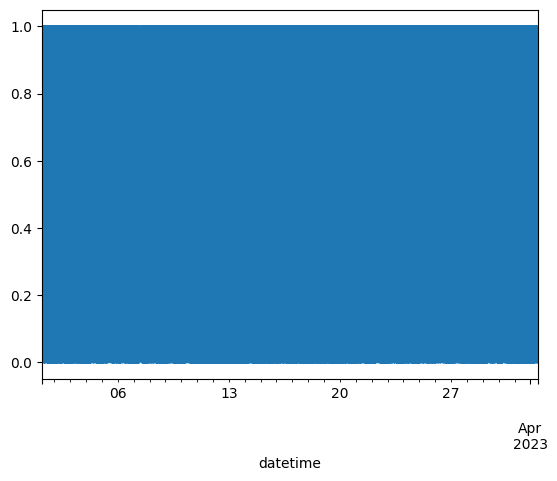

In [104]:
res_kns.smoothed_marginal_probabilities[0].plot()

<Axes: xlabel='datetime'>

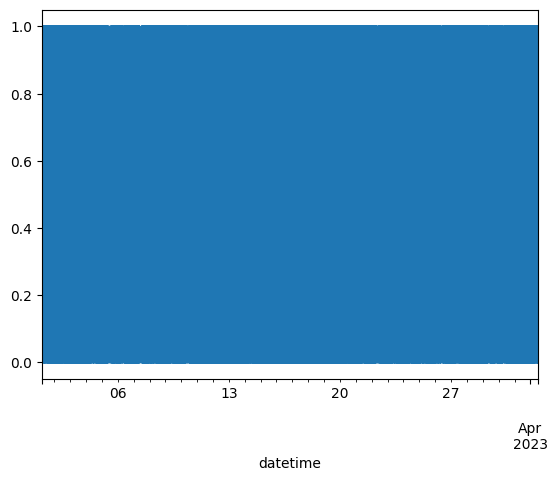

In [105]:
res_kns.smoothed_marginal_probabilities[1].plot()